# Check the property of device and versions

In [ ]:
# !pip install -U "transformers>=4.43.0"

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
!python --version

Python 3.12.8


In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# Run the following to empty the VRAM:
import gc
import torch
# del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

In [5]:
!nvidia-smi

Tue Apr  8 00:07:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     Off |   00000000:25:00.0 Off |                    0 |
|  0%   46C    P8             24W /  150W |       4MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Document Preprocessing

In [6]:
# use the Class
from embed_from_file import EmbeddingFromFile
# Call the class
pdf_path = ["articles/GettingStarted.pdf", "articles/human-nutrition-text.pdf"]
embedder = EmbeddingFromFile(pdf_path= pdf_path, 
                             embed_path="articles/text_chunks_and_embeddings_df.csv",
                            device = "cuda")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
# Create markeddown text using pymupdf4llm
md_text = embedder.markeddown_text(page_chunks=True, show_progress=True)

Processing articles/GettingStarted.pdf...
]========================================] (88/88)
Processing articles/human-nutrition-text.pdf...
]========================================] (1208/1208)


In [8]:
# Creating dictionary with page num, token num, content and sentences using NLP LLM model
pages_text = embedder.page_and_text(md_text,first_page= 1)

Processing Pages: 100%|██████████| 1295/1295 [00:02<00:00, 483.86it/s]


In [9]:
# Creating chunked
chunked = embedder.create_chunk(pages_and_texts = pages_text, slice_size=10)

# Filtered dataset excluding chunks less than certain number of tokens
filtered = embedder.df_with_min_chunk_length(pages_and_chunks=chunked, min_token_length=30)

Creating Chunks: 100%|██████████| 1295/1295 [00:00<00:00, 63126.12it/s]


In [10]:
# Creating embedding and pandas dataframe and saved the embeddings
df_with_embeddings = embedder.sentence_embeddings(filtered, model="all-mpnet-base-v2")

/home/jovyan/RAG/rag_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Generating Embeddings: 100%|██████████| 1747/1747 [04:06<00:00,  7.10it/s]


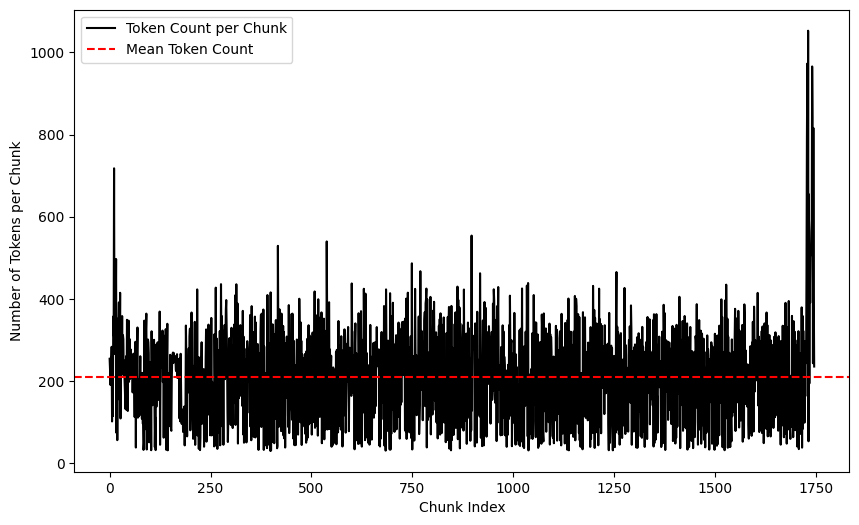

In [11]:
# Plotting the stats i.e., chunk index vs token per chunks
embedder.plot_stats()

In [12]:
import random

random.sample(chunked, k=2)

[{'page_number': 456,
  'sentence_chunk': 'Protein-rich Foods by [Smastronard](https://commons.wikimedia.org/wiki/File:Protein-rich_Foods.jpg) [o](https://commons.wikimedia.org/wiki/File:Protein-rich_Foods.jpg) / [CC](https://creativecommons.org/licenses/by-sa/4.0/deed.en) BY - [SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en)  Examples of complete protein sources include soy, dairy products,  meat, and seafood. Examples of incomplete protein sources include  legumes and corn.  Most plant-based foods are deficient in at least one essential  amino acid and therefore are incomplete protein sources. For  example, grains are usually deficient in the amino acid lysine, and  legumes are deficient in methionine or tryptophan. Because grains  and legumes are not deficient in the same amino acids they can  complement each other in a diet. Incomplete protein foods are  called complementary foods because when consumed in tandem  they contain all nine essential amino acids at adequa

# RAG - Search and Retrieval

### Load the saved embedded dataframe

In [ ]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("articles/text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

### Load the sentense fransformer model and create embedding from saved CSV file or alternatively, use the previously saved embedding.

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

In [ ]:
# Define helper function to print wrapped text 
import textwrap
from time import perf_counter as timer

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [ ]:
query = "What are the macronutrients, and what roles do they play in the human body?"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

In [ ]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

## Check device 

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

In [ ]:
# Run the following to empty the VRAM:
import gc
import torch
# del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

# Load huggingface Text Generation LLM

In [ ]:
# huggingface-cli download meta-llama/Llama-3.2-1B-Instruct --include "original/*" --local-dir Llama-3.2-1B-Instruct


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# Load model
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=False)

### Check the model size and memory requirements

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(model)

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(model)

# Text Generation using LLM without RAG

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

In [ ]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """
    Based on the following context items, please answer the query.
    Give yourself room to think by extracting relevant passages from the context before answering the query.
    Don't return the thinking, only return the answer.
    Make sure your answers are as explanatory as possible.
    Use the following examples as reference for the ideal answer style.
    \nExample 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
    \nExample 2:
    Query: What are the causes of type 2 diabetes?
    Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
    \nExample 3:
    Query: What is the importance of hydration for physical performance?
    Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
    \nNow use the following context items to answer the user query:
    {context}
    \nRelevant passages: <extract relevant passages from the context here>
    User query: {query}
    Answer:
    """

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [ ]:
def ask(query, 
        temperature=0.6,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items